# Example: Apply the median_transfer_function model

This notebook demonstrates how to calculate and apply a median transfer function.  Related code is defined in `src/median_transfer_function.py` and the input data should be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and saved to the `input_data` folder.

In [1]:
import colorcet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from matplotlib.gridspec import GridSpec

from src import das_xarray_helpers
from src import plots
from src import median_transfer_function
from src import waves

Input data can be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and should be saved to the `input_data` folder. See `input_data/README.md` for additional details on the data files and structure.

In [2]:
HOURLY_DAS_MOORING_DATA_PATH = 'input_data/oliktok_das_mooring_hourly_dataset.nc'

The median transfer function uses hourly DAS data.

In [3]:
das_60min_ds = xr.open_dataset(HOURLY_DAS_MOORING_DATA_PATH)

Reindex the dataset by site.

In [4]:
das_60min_ds = das_xarray_helpers.index_by_site(das_60min_ds)

Define the training time period.

In [5]:
# This should match the period used to train the neural networks
train_period = slice(pd.Timestamp('2023-08-23T12:00'), pd.Timestamp('2023-09-01T00:00'))

Calculate median transfer functions for each site using the training dataset.

In [6]:
# Calculate a median transfer function from training data at each site.
# Here, RatioTransferFunction is a simple class for calculating the the
# transfer function (stored as a DataArray) and saving/loading
# previously calculated transfer functions.
def calculate_median_transfer_function(
    das_ds: xr.Dataset,
) -> median_transfer_function.RatioTransferFunction:
    median_tf = median_transfer_function.RatioTransferFunction()
    median_tf.calculate(
        pressure_spectra=das_ds['target_seafloor_pressure_spectral_density'],
        strain_spectra=das_ds['strain_spectral_density'],
        statistic='median',
    )
    return median_tf


sites = das_60min_ds.indexes['site'].unique()

median_transfer_functions = {}
for site in sites:
    median_transfer_functions[site] = calculate_median_transfer_function(
        das_60min_ds.sel(site=site, time=train_period),
    )
    # Save and load as:
    # median_transfer_functions[site].save(
    #     path=f'./median_transfer_function_site_{int(site)}.pickle'
    # )
    # median_transfer_function.RatioTransferFunction.load(
    #     path=f'./median_transfer_function_site_{int(site)}.pickle'
    # )


Apply the median transfer functions (per site) to the entire dataset.

In [7]:
das_60min_ds["seafloor_pressure_spectral_density"] = xr.full_like(
    das_60min_ds['strain_spectral_density'],
    fill_value=np.nan
)
das_60min_ds["seafloor_pressure_spectral_density"].attrs = {}

for site in sites:
    das_60min_ds['seafloor_pressure_spectral_density'].loc[{'site': site}] \
        = median_transfer_functions[site](
            das_60min_ds.sel(site=site)['strain_spectral_density']
        )


Plot all transfer functions over time and the median transfer function for each site.

Text(0, 0.5, 'transfer function (-)')

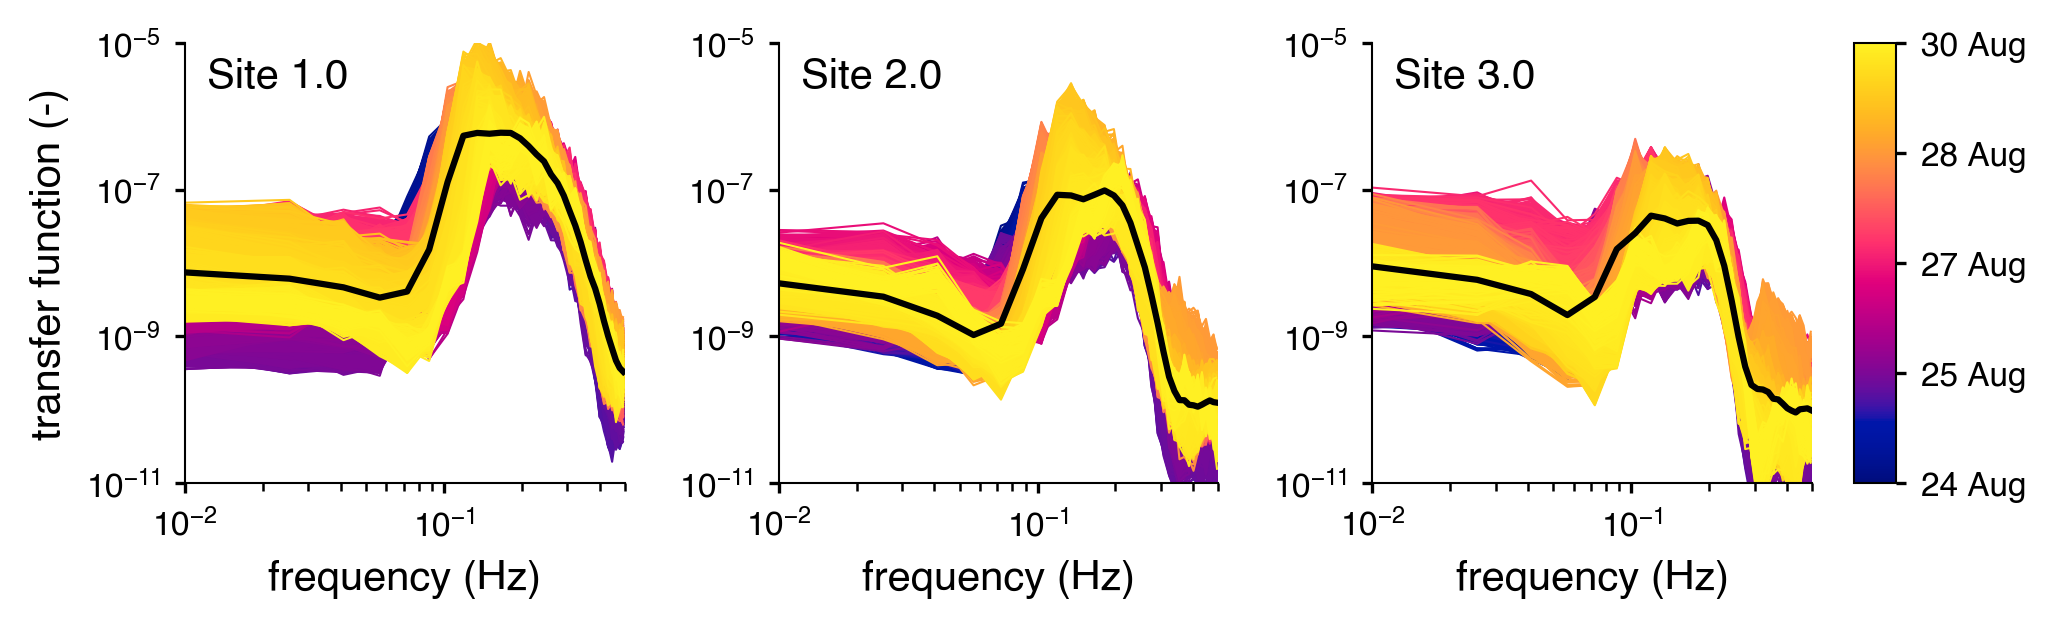

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(7.00, 2.5), gridspec_kw={'wspace': 0.35})

norm = mpl.colors.Normalize(
    vmin=pd.Timestamp('2023-08-24').value,
    vmax=pd.Timestamp('2023-08-30').value,
)
cmap = colorcet.cm.bmy

for ax, site in zip(axes, sites):
    # Compute all transfer functions during the training period.
    das_60min_subset_ds = das_60min_ds.sel(site=site, time=train_period)
    all_tf = das_60min_subset_ds['target_seafloor_pressure_spectral_density'] / das_60min_subset_ds['strain_spectral_density']

    lc = plots.plot_spectra_by_time(
        all_tf,
        ax=ax,
        linewidth=0.5,
        norm=norm,
        cmap=cmap,
        plot_colorbar=False,
    )
    plots.plot_spectra(
        median_transfer_functions[site].transfer_function,
        ax=ax,
        color='k',
        linestyle='-',
        label='median',
    )
    ax.set_ylim((10**(-11), 10**(-5)))
    ax.set_xlim([0.01, 0.5])
    ax.annotate(f'Site {site}', xy=(0.05, 0.9), xycoords='axes fraction')
    plots.set_square_aspect(ax)
    plots.remove_top_and_right_spines(ax)

# Create a colorbar for the time-colored lines.
cax = fig.add_axes([
    axes[-1].get_position().xmax + 0.02,
    axes[-1].get_position().ymin,
    0.02,
    axes[-1].get_position().ymax - axes[1].get_position().ymin,
])
cbar = fig.colorbar(lc, cax=cax, orientation="vertical")
cbar_dates = pd.date_range(start=lc.norm.vmin, end=lc.norm.vmax, periods=5)
cbar.set_ticks(ticks=pd.to_numeric(cbar_dates), labels=cbar_dates.strftime('%d %b'))

axes[0].set_ylabel('transfer function (-)')

Compare target and prediction spectra at a random channel and time index.

Text(0.5, 1.0, 'Example test prediction\nch=2496, time=2023-09-20 00:00')

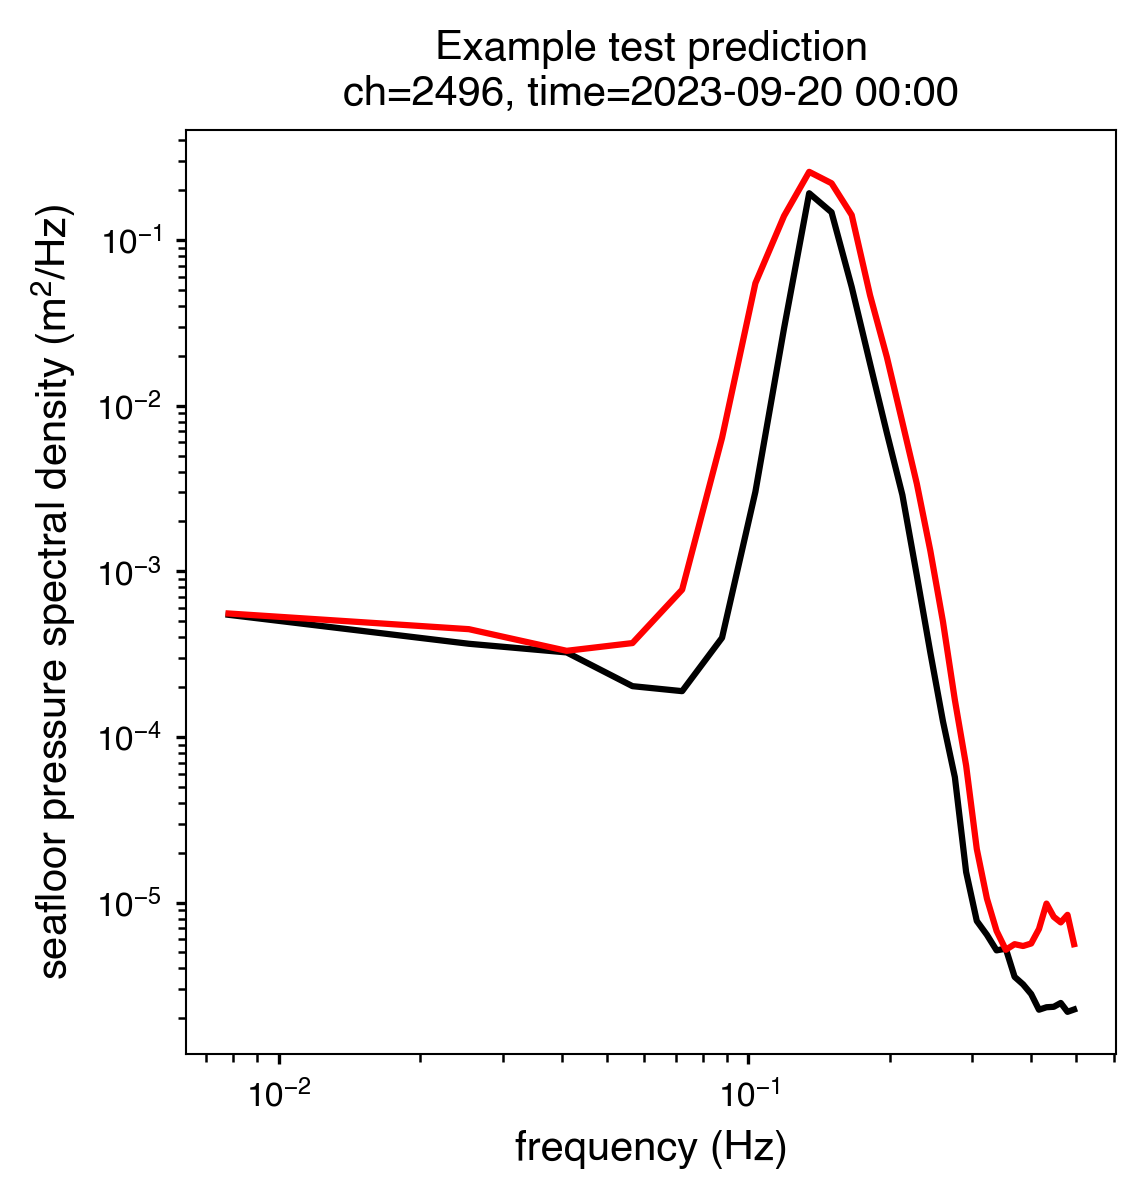

In [9]:
ch = np.random.choice(das_60min_ds['ch'].size)
time = np.random.choice(das_60min_ds['time'].size)

if das_60min_ds.isel(ch=ch, time=time)['is_train']:
    title_label = 'training'
    prediction_color = 'b'
else:
    title_label = 'test'
    prediction_color = 'r'

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(
    das_60min_ds['frequency'],
    das_60min_ds.isel(ch=ch, time=time)['target_seafloor_pressure_spectral_density'],
    color='k',
    label='target',
)
ax.loglog(
    das_60min_ds['frequency'],
    das_60min_ds.isel(ch=ch, time=time)['seafloor_pressure_spectral_density'],
    color=prediction_color,
    label='prediction',
)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('seafloor pressure spectral density (m$^2$/Hz)')
ax.set_title(
    f'Example {title_label} prediction\n'
    f'ch={das_60min_ds.ch[ch].item()}, '
    f'time={das_60min_ds.time[time].dt.strftime("%Y-%m-%d %H:%M").item()}'
)

Transform seafloor pressure spectral densities to surface elevation spectral densities and compute bulk variables.

In [10]:
# Attenuation cutoff is set to remove erroneous tail shape.
ATTENUATION_CUTOFF = 25

das_60min_ds['seafloor_pressure_variance'] = waves.spectral_var(
    das_60min_ds['seafloor_pressure_spectral_density']
)

das_60min_ds['energy_period'] = waves.energy_period(
    das_60min_ds['seafloor_pressure_spectral_density'],
)

attenuation_tf = waves.pressure_spectra_to_surface_spectra(
    depth=das_60min_ds['depth'],
    frequency=das_60min_ds['frequency'],
)

das_60min_ds['pressure_to_surface_transfer_function'] = attenuation_tf.where(
    attenuation_tf < ATTENUATION_CUTOFF,
    np.nan
)

das_60min_ds['surface_elevation_spectral_density'] = \
    das_60min_ds['seafloor_pressure_spectral_density'] * das_60min_ds['pressure_to_surface_transfer_function']

das_60min_ds['significant_wave_height'] = waves.significant_wave_height(
    das_60min_ds['surface_elevation_spectral_density'].fillna(0)  # Could handle NaNs better here.
)


Separate training and test datasets for plotting.

In [11]:
das_60min_train_ds = das_xarray_helpers.get_train(das_60min_ds)
das_60min_test_ds = das_xarray_helpers.get_test(das_60min_ds)

Plot the training, test, and target significant wave heights over the entire analysis period.

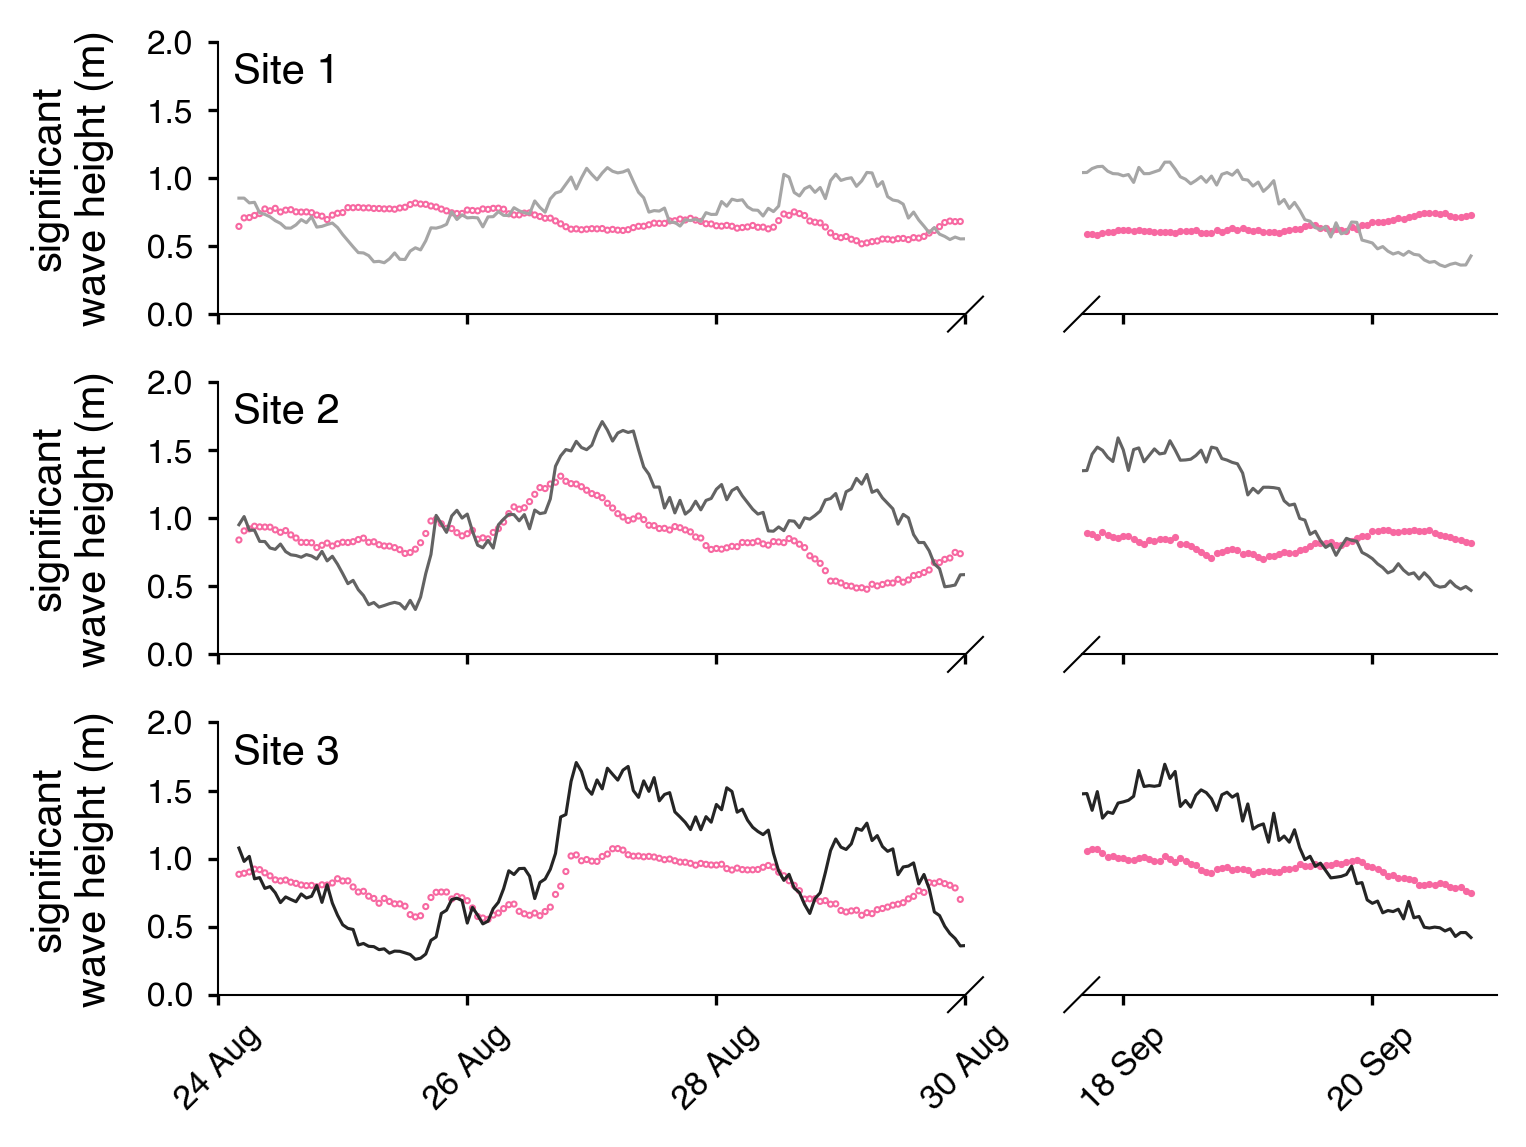

In [12]:
sites = [1, 2, 3]
start_time = pd.Timestamp('2023-08-24')
end_time = pd.Timestamp('2023-09-21')

# Create a three-panel time series using the brokenaxes package.
fig = plt.figure(figsize=(plots.figure_full_width, plots.figure_full_width*3/4))
gridspec = GridSpec(3, 1, hspace=0.25, wspace=0.1)
ax_1 = plots.create_time_series_axes(start_time, end_time, gridspec[0])
ax_2 = plots.create_time_series_axes(start_time, end_time, gridspec[1])
ax_3 = plots.create_time_series_axes(start_time, end_time, gridspec[2])
axes = [ax_1, ax_2, ax_3]

for ax, site in zip(axes, sites):
    ax.scatter(
        das_60min_train_ds.sel(site=site)['time'],
        das_60min_train_ds.sel(site=site)['significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.median_tf_color,
        **plots.train_scatter_kwargs,
    )
    ax.scatter(
        das_60min_test_ds.sel(site=site)['time'],
        das_60min_test_ds.sel(site=site)['significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.median_tf_color,
        **plots.test_scatter_kwargs,
    )
    ax.plot(
        das_60min_ds.sel(site=site)['time'],
        das_60min_ds.sel(site=site)['target_significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.mooring_site_colors[site],
        **plots.mooring_plot_kwargs,
    )
    ax.axs[0].annotate(f'Site {site}', xy=(0.02, 0.85), xycoords='axes fraction')
    ax.set_ylim([0, 2])
    ax.set_ylabel('significant\nwave height (m)', labelpad=25)
    plots.configure_time_series_xaxis(
        start_time, end_time, ax,
        labels=True if ax==axes[-1] else False
    )
